# Anomaly Detection v1

## Important note: This is just a prototype, do not use as a valid model or analysis

### importing libraries

In [1]:
%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import pandas_profiling

## Get Data

In [2]:
#folder where files are stored, it will be changed for blob storage
FOLDER_PATH = '.\InterfaceTraffic\\'

#list all files
files = os.listdir(FOLDER_PATH)

#loading first file to get column names set
df = pd.read_csv(FOLDER_PATH + files[0])
original_columns = df.columns
display(df.head())

#load the rest of files
df = df.append(pd.concat(
    [pd.read_csv(FOLDER_PATH+f, names=original_columns, header=0) for f in files[1:]], ignore_index=True))

NodeID  InterfaceID         DateTime  In_Averagebps  In_Minbps  In_Maxbps  \
0    3071        10912  11/14/2018 0:03      33568.895  33568.895  33568.895   
1    3071        10912  11/14/2018 0:12      23912.543  23912.543  23912.543   
2    3071        10912  11/14/2018 0:21      24765.508  24765.508  24765.508   
3    3071        10912  11/14/2018 0:30      36084.949  36084.949  36084.949   
4    3071        10912  11/14/2018 0:39      23879.447  23879.447  23879.447   

   In_TotalBytes  In_TotalPkts  In_AvgUniCastPkts  In_MinUniCastPkts  ...    \
0        2275179          6602          12.176065          12.176065  ...     
1        1614121          4978           9.218379           9.218379  ...     
2        1671697          5049           9.349859           9.349859  ...     
3        2435771          5414          10.025774          10.025774  ...     
4        1611887          4751           8.798016           8.798016  ...     

   Out_Maxbps  Out_TotalBytes  Out_TotalPkts  Out_AvgUniCastPkts  \
0   33775.219         2289163           8177           15.080837   
1   25298.492         1707674           6625           12.268333   
2   26966.318         1820254           6656           12.325740   
3   26080.227         1760442           6726           12.455367   
4   24752.441         1670815           6205           11.490567   

   Out_MaxUniCastPkts  Out_MinUniCastPkts  Out_AvgMultiCastPkts  \
0           15.080837           15.080837                     0   
1           12.268333           12.268333                     0   
2           12.325740           12.325740                     0   
3           12.455367           12.455367                     0   
4           11.490567           11.490567                     0   

   Out_MinMultiCastPkts  Out_MaxMultiCastPkts  Label  
0                     0                     0      0  
1                     0                     0      0  
2                     0                     0      0  
3                     0                     0      0  
4                     0                     0      0  

[5 rows x 26 columns]

In [3]:
#check types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1150 entries, 0 to 1122
Data columns (total 26 columns):
NodeID                  1145 non-null object
InterfaceID             1140 non-null float64
DateTime                1140 non-null object
In_Averagebps           1138 non-null float64
In_Minbps               1138 non-null float64
In_Maxbps               1138 non-null float64
In_TotalBytes           1138 non-null float64
In_TotalPkts            1140 non-null float64
In_AvgUniCastPkts       1140 non-null float64
In_MinUniCastPkts       1140 non-null float64
In_MaxUniCastPkts       1140 non-null float64
In_AvgMultiCastPkts     1140 non-null float64
In_MinMultiCastPkts     1140 non-null float64
In_MaxMultiCastPkts     1140 non-null float64
Out_Averagebps          1139 non-null float64
Out_Minbps              1139 non-null float64
Out_Maxbps              1139 non-null float64
Out_TotalBytes          1140 non-null float64
Out_TotalPkts           1140 non-null float64
Out_AvgUniCastPkts   

# Data Exploration

In [4]:
#check nulls
display(df.isnull().sum(axis = 0))
# tail to check end of file
display(df.tail())

NodeID                   5
InterfaceID             10
DateTime                10
In_Averagebps           12
In_Minbps               12
In_Maxbps               12
In_TotalBytes           12
In_TotalPkts            10
In_AvgUniCastPkts       10
In_MinUniCastPkts       10
In_MaxUniCastPkts       10
In_AvgMultiCastPkts     10
In_MinMultiCastPkts     10
In_MaxMultiCastPkts     10
Out_Averagebps          11
Out_Minbps              11
Out_Maxbps              11
Out_TotalBytes          10
Out_TotalPkts           10
Out_AvgUniCastPkts      10
Out_MaxUniCastPkts      10
Out_MinUniCastPkts      10
Out_AvgMultiCastPkts    10
Out_MinMultiCastPkts    10
Out_MaxMultiCastPkts    10
Label                   10
dtype: int64

NodeID  InterfaceID          DateTime  In_Averagebps  In_Minbps  \
1118   3071      10912.0  11/21/2018 23:23      25717.123  25717.123   
1119   3071      10912.0  11/21/2018 23:32      36598.938  36598.938   
1120   3071      10912.0  11/21/2018 23:41      40754.551  40754.551   
1121   3071      10912.0  11/21/2018 23:50      31373.359  31373.359   
1122   3071      10912.0  11/21/2018 23:59      26111.961  26111.961   

      In_Maxbps  In_TotalBytes  In_TotalPkts  In_AvgUniCastPkts  \
1118  25717.123      1735932.0        5049.0           9.349859   
1119  36598.938      2470537.0        7494.0          13.877167   
1120  40754.551      2750894.0        5723.0          10.598295   
1121  31373.359      2117795.0        5893.0          10.912482   
1122  26111.961      1762533.0        5145.0           9.527909   

      In_MinUniCastPkts  ...    Out_Maxbps  Out_TotalBytes  Out_TotalPkts  \
1118           9.349859  ...     28901.609       1950888.0         6831.0   
1119          13.877167  ...     42309.723       2856032.0         9474.0   
1120          10.598295  ...     28041.367       1892766.0         7273.0   
1121          10.912482  ...     29864.063       2015913.0         7613.0   
1122           9.527909  ...     27553.537       1859838.0         6897.0   

      Out_AvgUniCastPkts  Out_MaxUniCastPkts  Out_MinUniCastPkts  \
1118           12.649809           12.649809           12.649809   
1119           17.543673           17.543673           17.543673   
1120           13.468705           13.468705           13.468705   
1121           14.097528           14.097528           14.097528   
1122           12.772399           12.772399           12.772399   

      Out_AvgMultiCastPkts  Out_MinMultiCastPkts  Out_MaxMultiCastPkts  Label  
1118                   0.0                   0.0                   0.0    0.0  
1119                   0.0                   0.0                   0.0    0.0  
1120                   0.0                   0.0                   0.0    0.0  
1121                   0.0                   0.0                   0.0    0.0  
1122                   0.0                   0.0                   0.0    0.0  

[5 rows x 26 columns]

In [5]:
#removing Nulls. 
# in some files there was the Query note "(160 rows affected)" appended as a line 
# which was bringing nulls
display(df.dropna(inplace=True))
#df = df[~df['In_AvgMultiCastPkts'].isin(['----','[A-Za-z]'])]

#forcing casting for IDs as strings
df.InterfaceID = df.InterfaceID.astype('str')
df.NodeID = df.NodeID.astype('str')

None

In [6]:
#set column 'DateTime' as datetime for time manipulation
df.DateTime = pd.to_datetime(df.DateTime)

In [7]:
#get description of variables
display(df.describe())

#check unique values
display(df.nunique())

In_Averagebps     In_Minbps     In_Maxbps  In_TotalBytes  \
count   1.137000e+03  1.137000e+03  1.137000e+03   1.137000e+03   
mean    1.212335e+05  1.212335e+05  1.212335e+05   8.152142e+06   
std     1.754134e+05  1.754134e+05  1.754134e+05   1.183763e+07   
min     1.835818e+04  1.835818e+04  1.835818e+04   7.131600e+04   
25%     2.757859e+04  2.757859e+04  2.757859e+04   1.862305e+06   
50%     5.631495e+04  5.631495e+04  5.631495e+04   3.801317e+06   
75%     1.356932e+05  1.356932e+05  1.356932e+05   9.082668e+06   
max     1.379918e+06  1.379918e+06  1.379918e+06   9.314859e+07   

        In_TotalPkts  In_AvgUniCastPkts  In_MinUniCastPkts  In_MaxUniCastPkts  \
count    1137.000000        1137.000000        1137.000000        1137.000000   
mean    16285.093228          30.389581          30.389581          30.389581   
std     18885.520328          35.335937          35.335937          35.335937   
min       260.000000           7.538775           7.538775           7.538775   
25%      5264.000000           9.835027           9.835027           9.835027   
50%      6912.000000          13.000000          13.000000          13.000000   
75%     21030.000000          39.000000          39.000000          39.000000   
max    155819.000000         288.000000         288.000000         288.000000   

       In_AvgMultiCastPkts  In_MinMultiCastPkts     ...         Out_Maxbps  \
count               1137.0               1137.0     ...       1.137000e+03   
mean                   0.0                  0.0     ...       7.005924e+04   
std                    0.0                  0.0     ...       8.121224e+04   
min                    0.0                  0.0     ...       1.940066e+04   
25%                    0.0                  0.0     ...       2.725935e+04   
50%                    0.0                  0.0     ...       3.160374e+04   
75%                    0.0                  0.0     ...       9.080104e+04   
max                    0.0                  0.0     ...       1.120072e+06   

       Out_TotalBytes  Out_TotalPkts  Out_AvgUniCastPkts  Out_MaxUniCastPkts  \
count    1.137000e+03    1137.000000         1137.000000         1137.000000   
mean     4.693381e+06   18697.883026           34.910087           34.910087   
std      5.420891e+06   20369.515221           38.277495           38.277495   
min      5.498200e+04     306.000000           10.231919           10.231919   
25%      1.839981e+06    6848.000000           12.681291           12.681291   
50%      2.136669e+06    8222.000000           15.225093           15.225093   
75%      6.095726e+06   22393.000000           42.293781           42.293781   
max      7.563884e+07  147945.000000          273.849240          273.849240   

       Out_MinUniCastPkts  Out_AvgMultiCastPkts  Out_MinMultiCastPkts  \
count         1137.000000                1137.0                1137.0   
mean            34.910087                   0.0                   0.0   
std             38.277495                   0.0                   0.0   
min             10.231919                   0.0                   0.0   
25%             12.681291                   0.0                   0.0   
50%             15.225093                   0.0                   0.0   
75%             42.293781                   0.0                   0.0   
max            273.849240                   0.0                   0.0   

       Out_MaxMultiCastPkts        Label  
count                1137.0  1137.000000  
mean                    0.0     0.007036  
std                     0.0     0.083622  
min                     0.0     0.000000  
25%                     0.0     0.000000  
50%                     0.0     0.000000  
75%                     0.0     0.000000  
max                     0.0     1.000000  

[8 rows x 23 columns]

NodeID                     1
InterfaceID                1
DateTime                1137
In_Averagebps           1137
In_Minbps               1137
In_Maxbps               1137
In_TotalBytes           1131
In_TotalPkts            1070
In_AvgUniCastPkts        770
In_MinUniCastPkts        770
In_MaxUniCastPkts        770
In_AvgMultiCastPkts        1
In_MinMultiCastPkts        1
In_MaxMultiCastPkts        1
Out_Averagebps          1134
Out_Minbps              1134
Out_Maxbps              1134
Out_TotalBytes          1123
Out_TotalPkts           1045
Out_AvgUniCastPkts      1124
Out_MaxUniCastPkts      1124
Out_MinUniCastPkts      1124
Out_AvgMultiCastPkts       1
Out_MinMultiCastPkts       1
Out_MaxMultiCastPkts       1
Label                      2
dtype: int64

In [8]:
# Names & Number of rows and columns
print('Number or rows:', df.shape[0])
print('Number or columns:', df.shape[1])

#print last 4 transposed rows
display(df.tail(4).T)

Number or rows: 1137
Number or columns: 26


1119                 1120  \
NodeID                               3071                 3071   
InterfaceID                       10912.0              10912.0   
DateTime              2018-11-21 23:32:00  2018-11-21 23:41:00   
In_Averagebps                     36598.9              40754.6   
In_Minbps                         36598.9              40754.6   
In_Maxbps                         36598.9              40754.6   
In_TotalBytes                 2.47054e+06          2.75089e+06   
In_TotalPkts                         7494                 5723   
In_AvgUniCastPkts                 13.8772              10.5983   
In_MinUniCastPkts                 13.8772              10.5983   
In_MaxUniCastPkts                 13.8772              10.5983   
In_AvgMultiCastPkts                     0                    0   
In_MinMultiCastPkts                     0                    0   
In_MaxMultiCastPkts                     0                    0   
Out_Averagebps                    42309.7              28041.4   
Out_Minbps                        42309.7              28041.4   
Out_Maxbps                        42309.7              28041.4   
Out_TotalBytes                2.85603e+06          1.89277e+06   
Out_TotalPkts                        9474                 7273   
Out_AvgUniCastPkts                17.5437              13.4687   
Out_MaxUniCastPkts                17.5437              13.4687   
Out_MinUniCastPkts                17.5437              13.4687   
Out_AvgMultiCastPkts                    0                    0   
Out_MinMultiCastPkts                    0                    0   
Out_MaxMultiCastPkts                    0                    0   
Label                                   0                    0   

                                     1121                 1122  
NodeID                               3071                 3071  
InterfaceID                       10912.0              10912.0  
DateTime              2018-11-21 23:50:00  2018-11-21 23:59:00  
In_Averagebps                     31373.4                26112  
In_Minbps                         31373.4                26112  
In_Maxbps                         31373.4                26112  
In_TotalBytes                  2.1178e+06          1.76253e+06  
In_TotalPkts                         5893                 5145  
In_AvgUniCastPkts                 10.9125              9.52791  
In_MinUniCastPkts                 10.9125              9.52791  
In_MaxUniCastPkts                 10.9125              9.52791  
In_AvgMultiCastPkts                     0                    0  
In_MinMultiCastPkts                     0                    0  
In_MaxMultiCastPkts                     0                    0  
Out_Averagebps                    29864.1              27553.5  
Out_Minbps                        29864.1              27553.5  
Out_Maxbps                        29864.1              27553.5  
Out_TotalBytes                2.01591e+06          1.85984e+06  
Out_TotalPkts                        7613                 6897  
Out_AvgUniCastPkts                14.0975              12.7724  
Out_MaxUniCastPkts                14.0975              12.7724  
Out_MinUniCastPkts                14.0975              12.7724  
Out_AvgMultiCastPkts                    0                    0  
Out_MinMultiCastPkts                    0                    0  
Out_MaxMultiCastPkts                    0                    0  
Label                                   0                    0

In [9]:
#check columns
df.columns

Index(['NodeID', 'InterfaceID', 'DateTime', 'In_Averagebps', 'In_Minbps',
       'In_Maxbps', 'In_TotalBytes', 'In_TotalPkts', 'In_AvgUniCastPkts',
       'In_MinUniCastPkts', 'In_MaxUniCastPkts', 'In_AvgMultiCastPkts',
       'In_MinMultiCastPkts', 'In_MaxMultiCastPkts', 'Out_Averagebps',
       'Out_Minbps', 'Out_Maxbps', 'Out_TotalBytes', 'Out_TotalPkts',
       'Out_AvgUniCastPkts', 'Out_MaxUniCastPkts', 'Out_MinUniCastPkts',
       'Out_AvgMultiCastPkts', 'Out_MinMultiCastPkts', 'Out_MaxMultiCastPkts',
       'Label'],
      dtype='object')

Let's get a quick snapshot of the dataset with the help of pandas_profiling a module that gives much more information than pandas' describe(). It provides Quantile Statistics, Descriptive statistics, most frequent values, histograms, correlations and more.

Computing profiling report


<IPython.core.display.Javascript object>


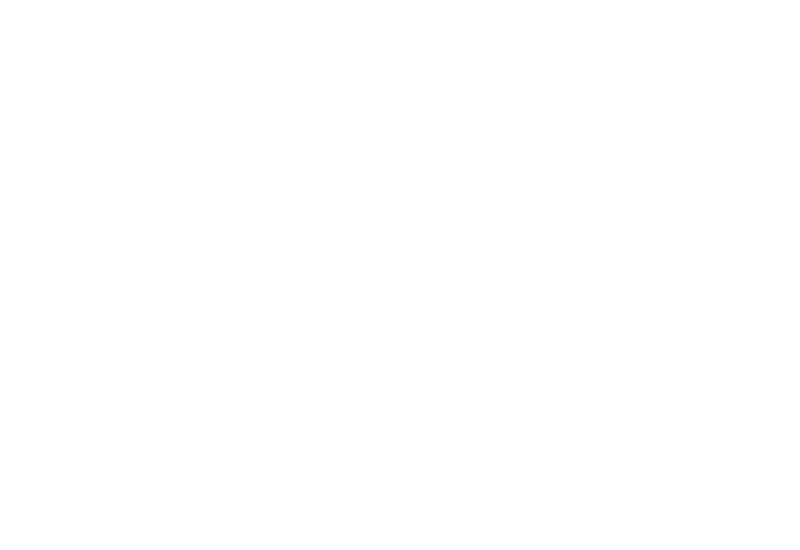

<IPython.core.display.Javascript object>


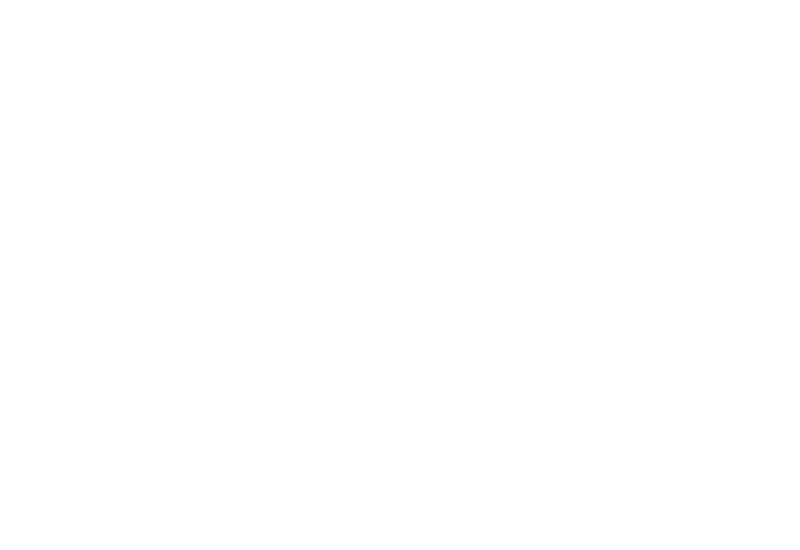

In [10]:
print('Computing profiling report')
pfr = pandas_profiling.ProfileReport(df,correlation_threshold = 0.99999)
#pfr.to_file('ProfileReport.html')
display(pfr)

## Data Transformation

In [11]:
#creating ID for future reference and mdoeling
df['NodeID_InterfaceID']=df.NodeID +'_'+ df.InterfaceID

#Removing Zero columns and old IDs
df.drop(columns=['NodeID','InterfaceID',
                 'Out_AvgMultiCastPkts','Out_MinMultiCastPkts','Out_MaxMultiCastPkts',
                 'In_AvgMultiCastPkts','In_MinMultiCastPkts','In_MaxMultiCastPkts'], inplace=True)
#creating time features, more can be added in the future 
df['TotalMinutes'] = df.DateTime.dt.hour*60 + df.DateTime.dt.minute
df['Day'] = df.DateTime.dt.day

From the profiling report results lets remove some variables

We will only keep the Average variable for each group, the rest will be removed because of high correlation (ρ = 1):

    In_MaxUniCastPkts is highly correlated with In_MinUniCastPkts (ρ = 1) Rejected
    In_MinUniCastPkts is highly correlated with In_AvgUniCastPkts (ρ = 1) Rejected
    
    Out_MinUniCastPkts is highly correlated with Out_MaxUniCastPkts (ρ = 1) Rejected
    Out_MaxUniCastPkts is highly correlated with Out_AvgUniCastPkts (ρ = 1) Rejected
    
    In_Maxbps is highly correlated with In_Minbps (ρ = 1) Rejected
    In_Minbps is highly correlated with In_Averagebps (ρ = 1) Rejected
    
    Out_Maxbps is highly correlated with Out_Minbps (ρ = 1) Rejected
    Out_Minbps is highly correlated with Out_Averagebps (ρ = 1) Rejected

In [12]:
#create compact dataframe
columns = ['DateTime',  'TotalMinutes', 'Day',
'In_TotalPkts', 'Out_TotalPkts',
'In_AvgUniCastPkts', 'Out_AvgUniCastPkts',
'In_Averagebps', 'Out_Averagebps',
'In_TotalBytes' ,'Out_TotalBytes',
'Label']
df4model = df[columns]
df4model.head()

DateTime  TotalMinutes  Day  In_TotalPkts  Out_TotalPkts  \
0 2018-11-14 00:03:00             3   14        6602.0         8177.0   
1 2018-11-14 00:12:00            12   14        4978.0         6625.0   
2 2018-11-14 00:21:00            21   14        5049.0         6656.0   
3 2018-11-14 00:30:00            30   14        5414.0         6726.0   
4 2018-11-14 00:39:00            39   14        4751.0         6205.0   

   In_AvgUniCastPkts  Out_AvgUniCastPkts  In_Averagebps  Out_Averagebps  \
0          12.176065           15.080837      33568.895       33775.219   
1           9.218379           12.268333      23912.543       25298.492   
2           9.349859           12.325740      24765.508       26966.318   
3          10.025774           12.455367      36084.949       26080.227   
4           8.798016           11.490567      23879.447       24752.441   

   In_TotalBytes  Out_TotalBytes  Label  
0      2275179.0       2289163.0    0.0  
1      1614121.0       1707674.0    0.0  
2      1671697.0       1820254.0    0.0  
3      2435771.0       1760442.0    0.0  
4      1611887.0       1670815.0    0.0

In [13]:
#check columns to plot
str(columns[1:11])

"['TotalMinutes', 'Day', 'In_TotalPkts', 'Out_TotalPkts', 'In_AvgUniCastPkts', 'Out_AvgUniCastPkts', 'In_Averagebps', 'Out_Averagebps', 'In_TotalBytes', 'Out_TotalBytes']"

<IPython.core.display.Javascript object>


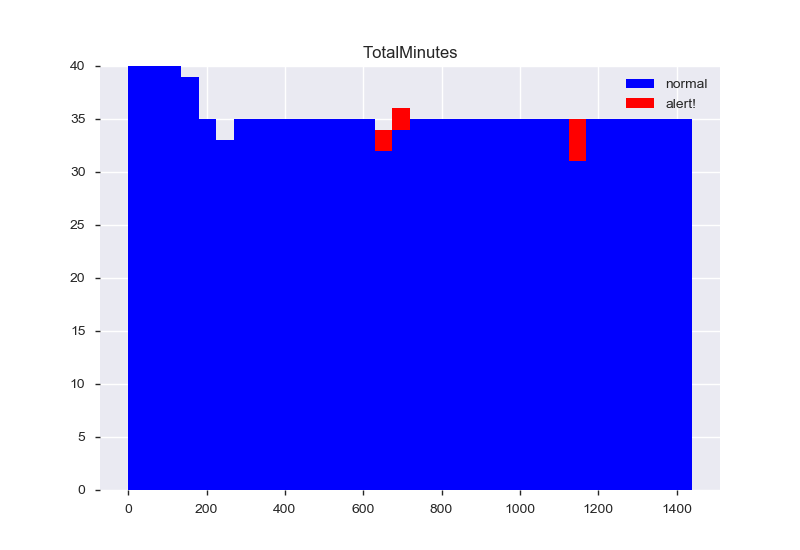

<IPython.core.display.Javascript object>


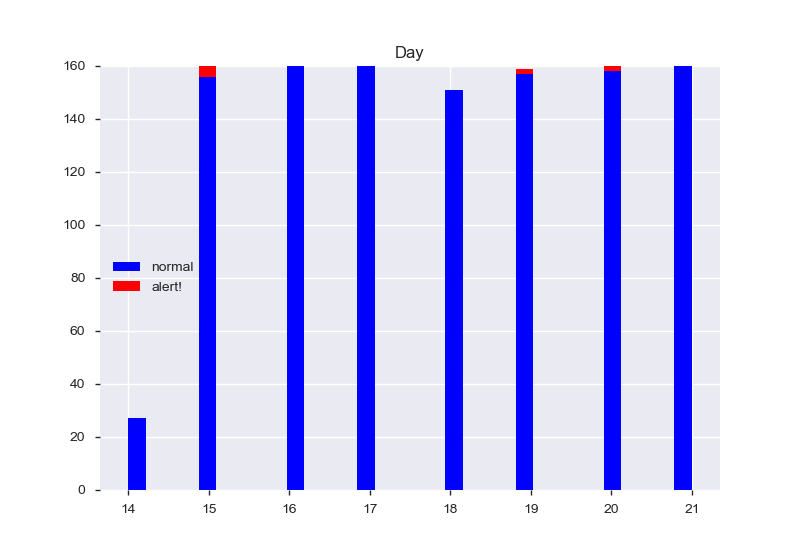

<IPython.core.display.Javascript object>


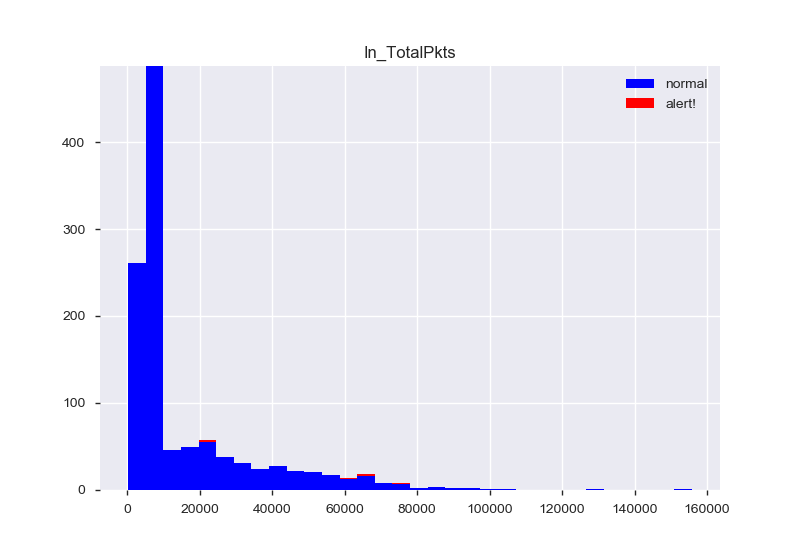

<IPython.core.display.Javascript object>


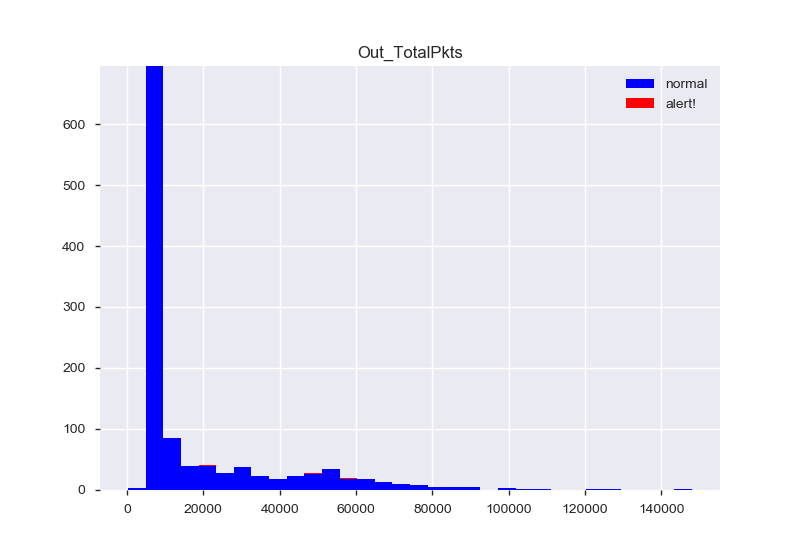

<IPython.core.display.Javascript object>


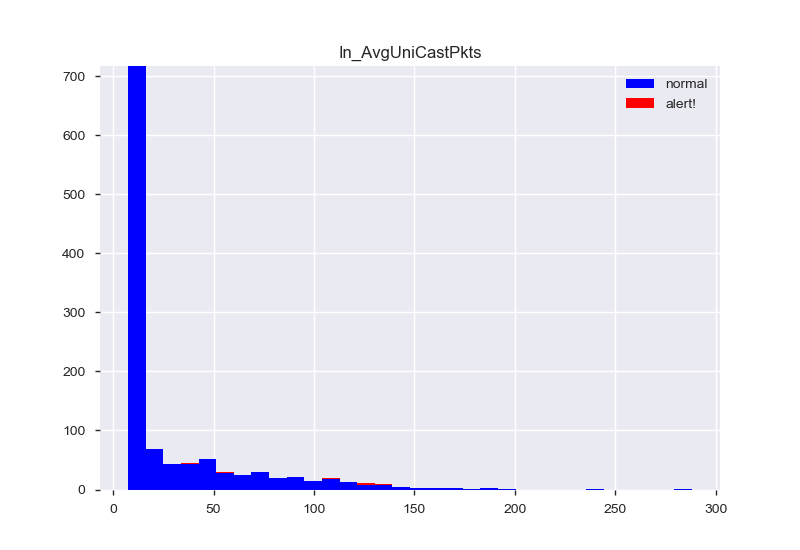

<IPython.core.display.Javascript object>


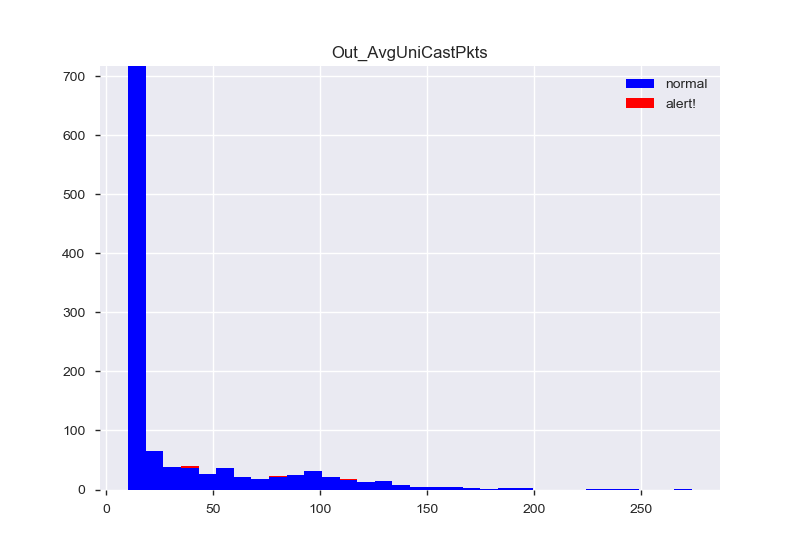

<IPython.core.display.Javascript object>


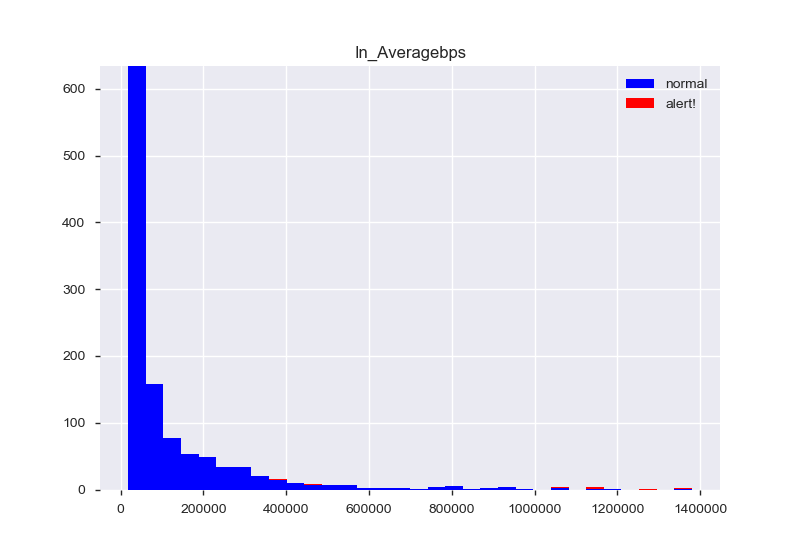

<IPython.core.display.Javascript object>


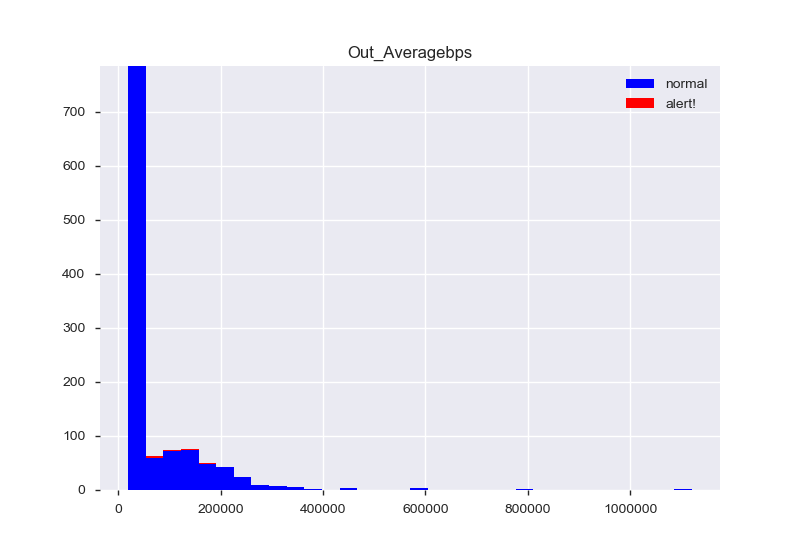

<IPython.core.display.Javascript object>


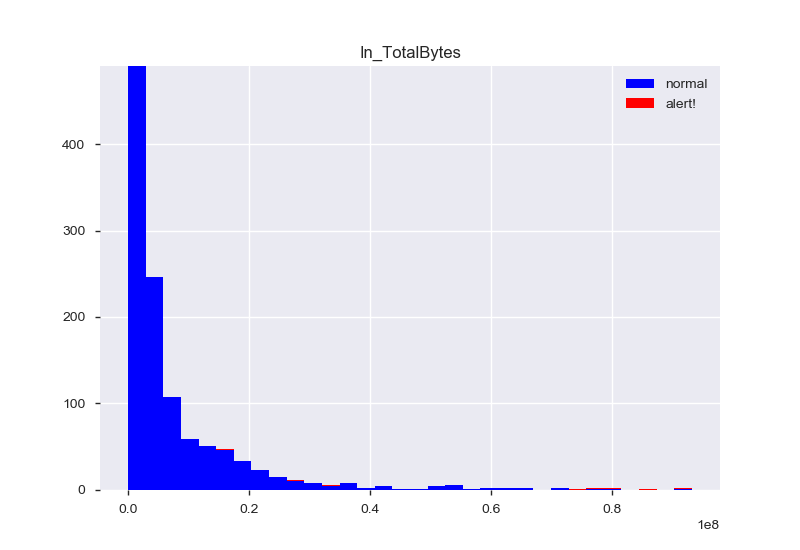

<IPython.core.display.Javascript object>


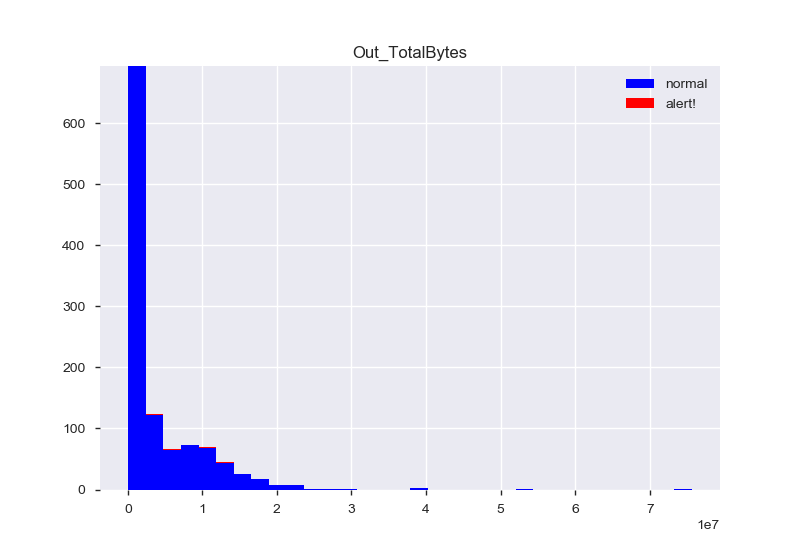

In [14]:
# Check distribution for variables
for column in columns[1:11]:
    a = df4model.loc[df4model['Label'] == 0, column]
    b = df4model.loc[df4model['Label'] == 1, column]

    fig, axs = plt.subplots()
    axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'alert!'])
    plt.legend()
    plt.title(column)
    plt.show()

<IPython.core.display.Javascript object>


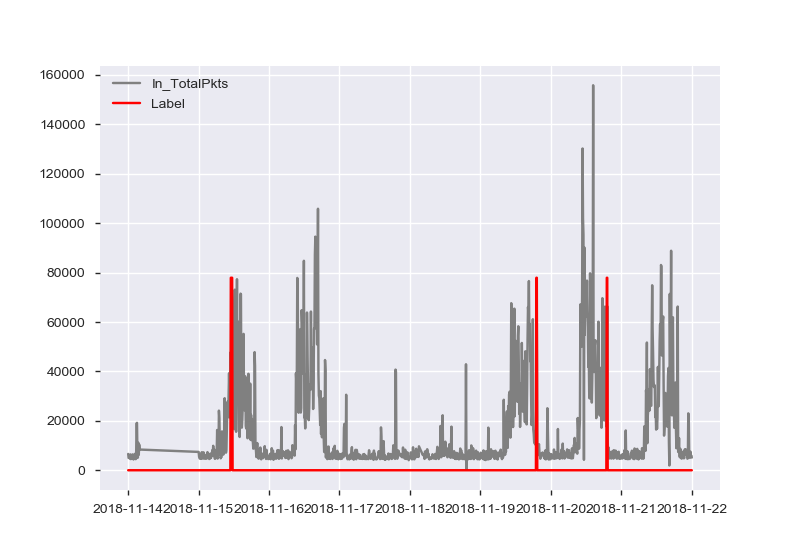

<IPython.core.display.Javascript object>


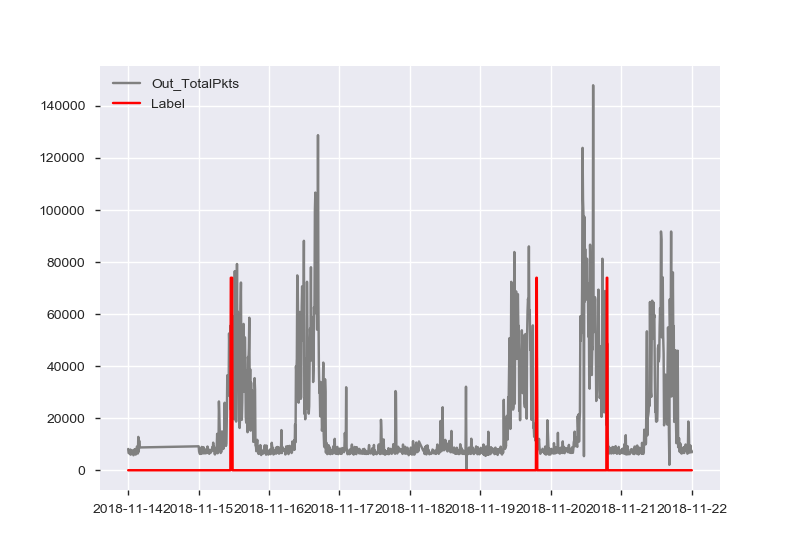

<IPython.core.display.Javascript object>


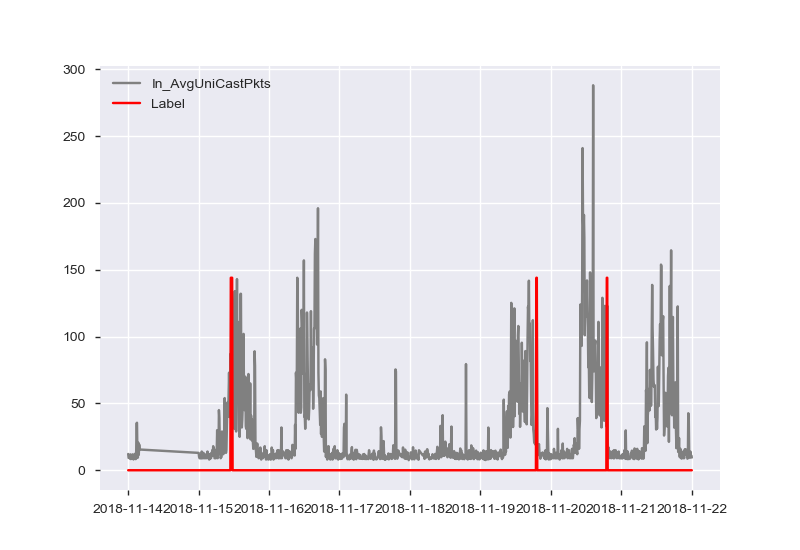

<IPython.core.display.Javascript object>


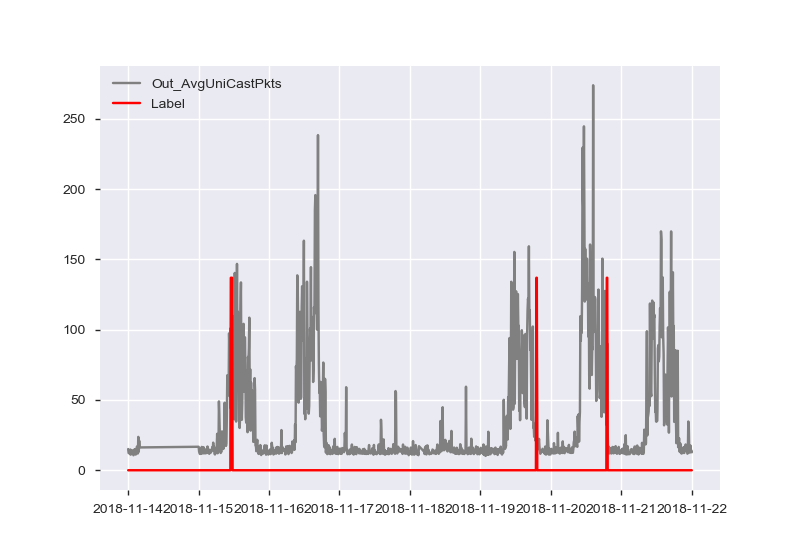

<IPython.core.display.Javascript object>


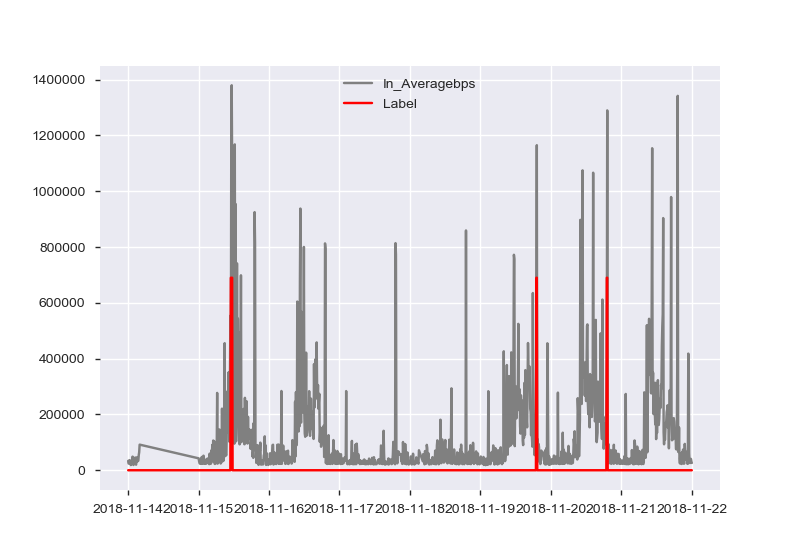

In [15]:
# plot in time of labeled alerts and selected variables
x = df4model['DateTime']

for column in columns[3:8]:
    fig, ax = plt.subplots()
    y1 = df4model[column]
    y2 = df4model['Label']*df4model[column].max() *0.5
    ax.plot(x, y1,  color='grey')
    ax.plot(x, y2, color='red' )
    plt.legend()
    plt.show()


# Modeling

Due to the small dataset, We will only create 2 unsupervised models: 

    1) Isolation Forest
    2) One class SVM

## Isolation Forest
Novel algorithm that uses the concept of decision tree to find the 'isolated' values

In [16]:
# Take useful feature and standardize them 
data = df4model[columns[1:11]]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = 0.01)
model.fit(data)
# add the data to the main  
df4model['Anomaly'] = pd.Series(model.predict(data))
df4model['Anomaly'] = df4model['Anomaly'].map( {1: 0, -1: 1} )
print(df4model['Anomaly'].value_counts())

0    1125
1      12
Name: Anomaly, dtype: int64


### Plot Anomaly (Blue | isolation Forest) with the rest of data 

<IPython.core.display.Javascript object>


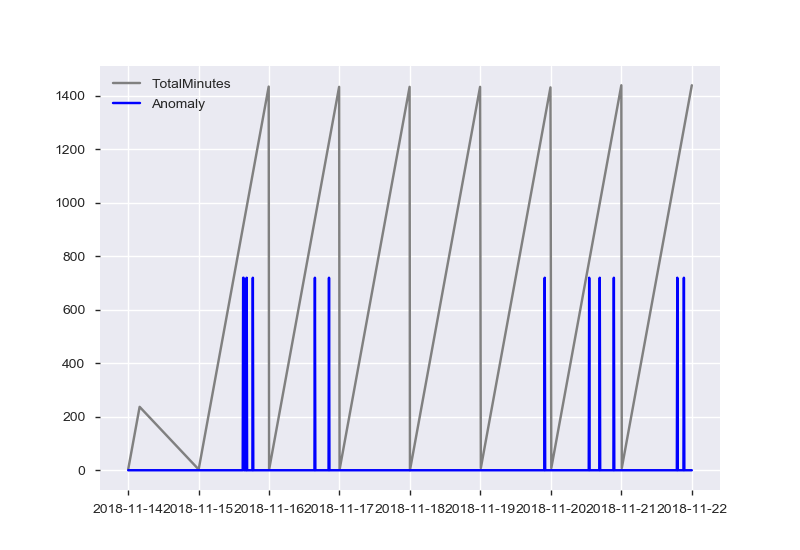

<IPython.core.display.Javascript object>


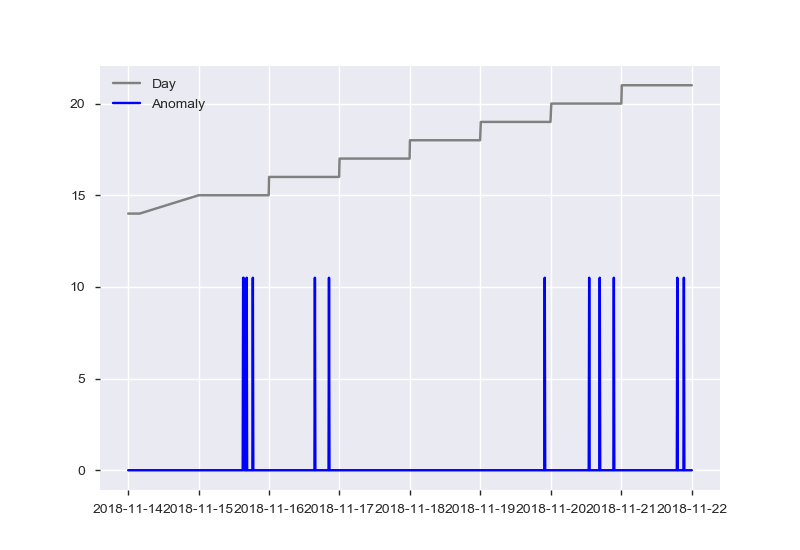

<IPython.core.display.Javascript object>


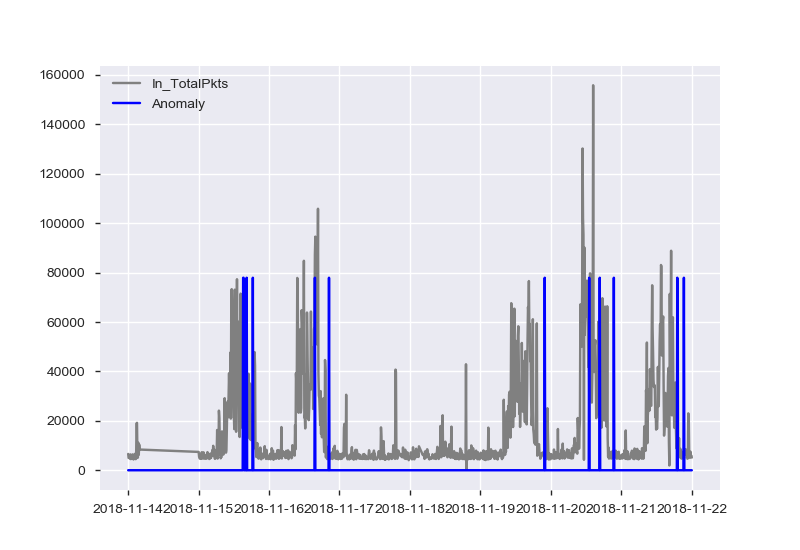

<IPython.core.display.Javascript object>


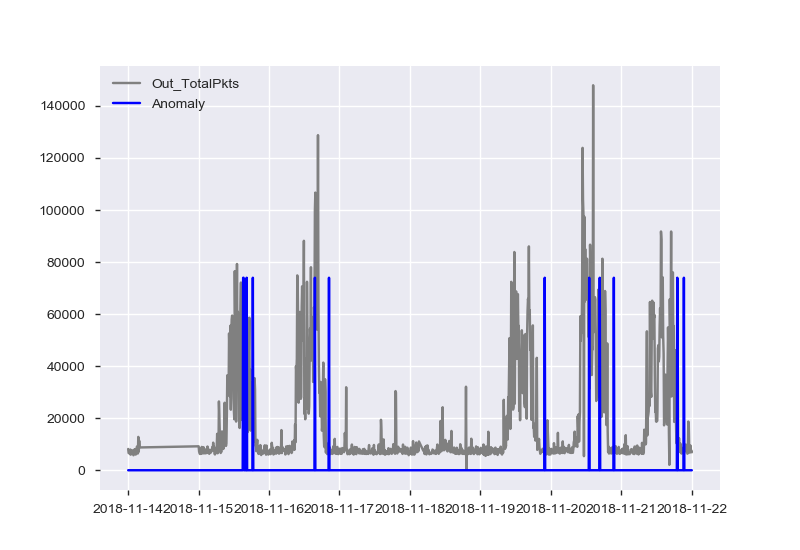

<IPython.core.display.Javascript object>


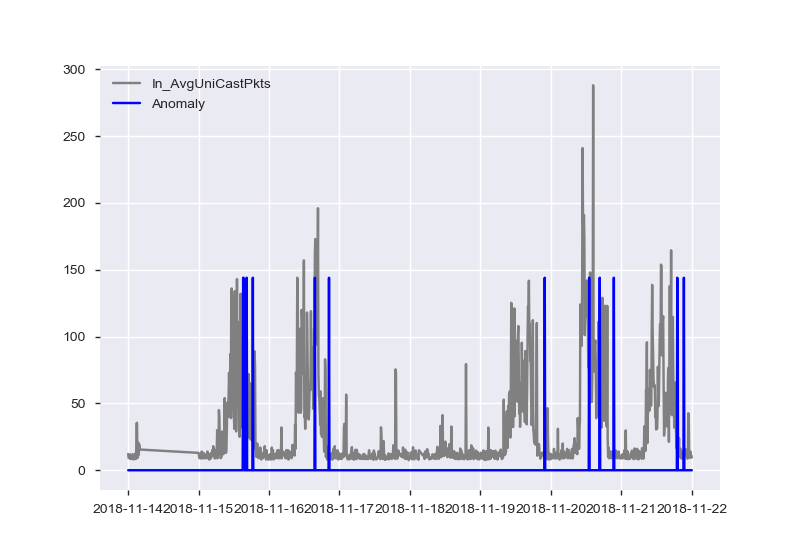

<IPython.core.display.Javascript object>


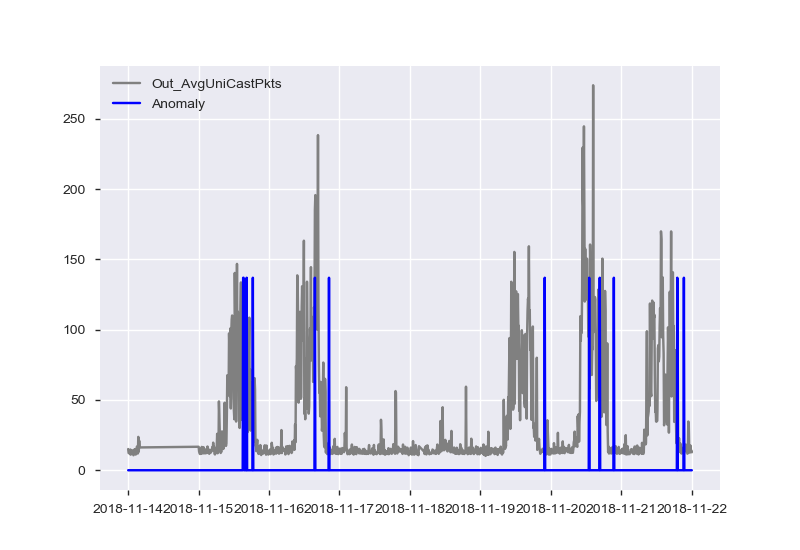

<IPython.core.display.Javascript object>


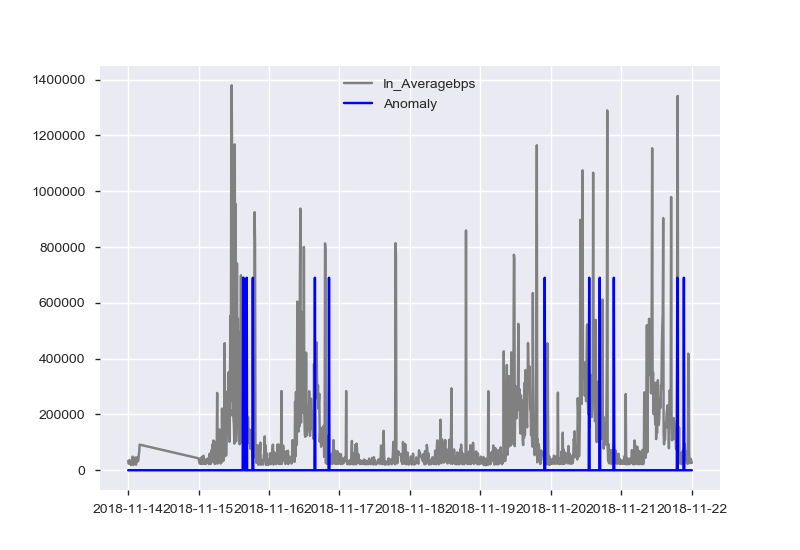

<IPython.core.display.Javascript object>


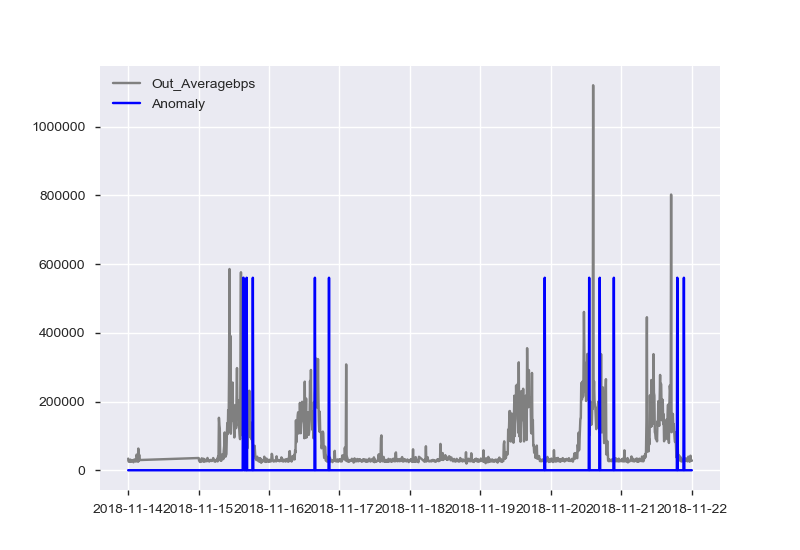

<IPython.core.display.Javascript object>


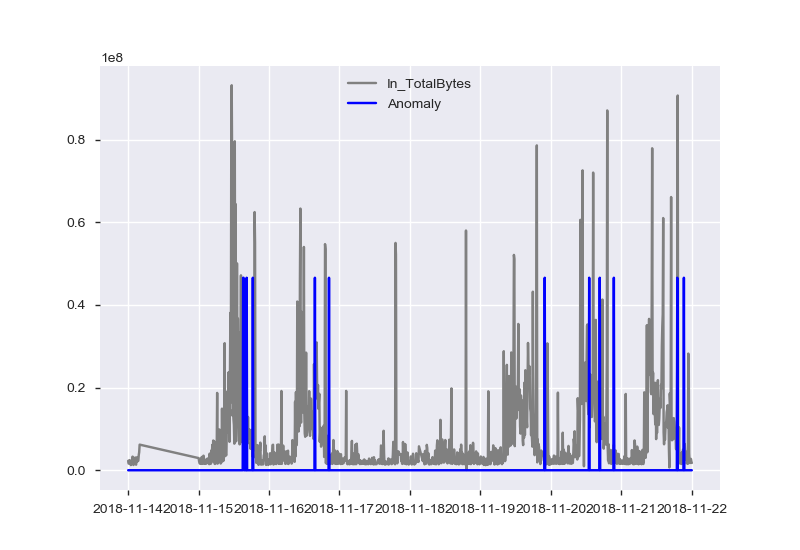

<IPython.core.display.Javascript object>


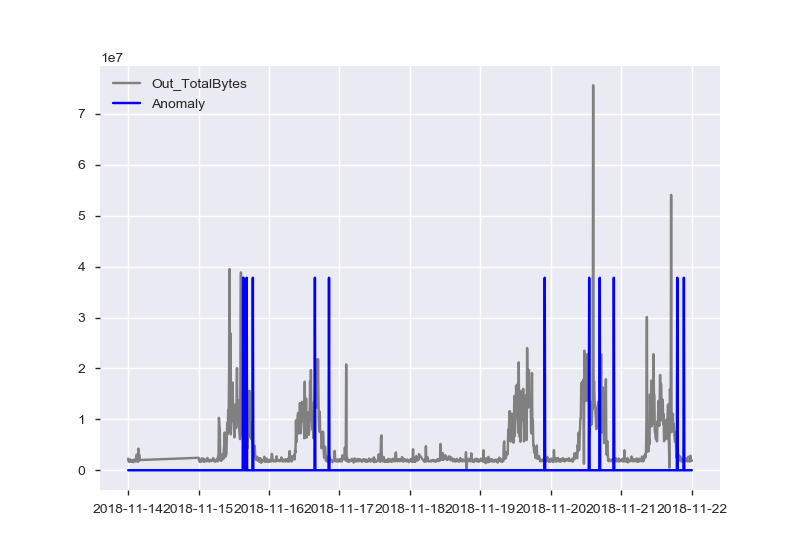

In [17]:
x = df4model['DateTime']

for column in columns[1:11]:
    fig, ax = plt.subplots()
    y1 = df4model[column]
    y3 = df4model['Anomaly']*df4model[column].max() *0.5
    ax.plot(x, y1,  color='grey')
    ax.plot(x, y3, color='blue' )  
    plt.legend()
    plt.show()

## One class Support Vector Machine

In this case the model gets used to normality and will trigger an alarm when gets something abnormal compared to its training set

In [18]:
# Take useful feature and standardize them 

train = df4model[columns[1:]][df4model['Label']==0]
test = df4model[columns[1:]]

min_max_scaler = preprocessing.StandardScaler()

train_scaled = min_max_scaler.fit_transform(train)
train = pd.DataFrame(train_scaled)

test_scaled = min_max_scaler.fit_transform(test)
test = pd.DataFrame(test_scaled)

# train one class SVM 
model =  OneClassSVM(nu=0.001) 
model.fit(train)

# add the data to the main  
df4model['Anomaly2'] = pd.Series(model.predict(test))
df4model['Anomaly2'] = df4model['Anomaly2'].map( {1: 0, -1: 1} )
print(df4model['Anomaly2'].value_counts())

0    1112
1      25
Name: Anomaly2, dtype: int64


### Plot Anomaly (Green | SVM) with the rest of data 

<IPython.core.display.Javascript object>


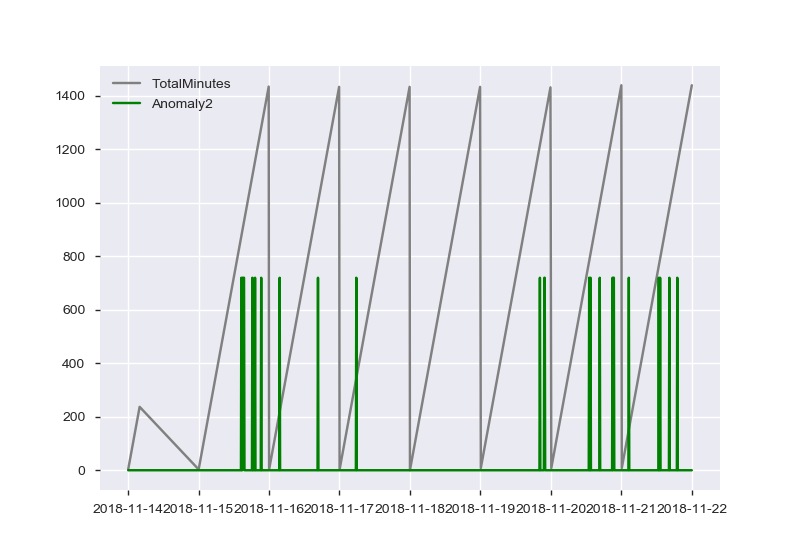

<IPython.core.display.Javascript object>


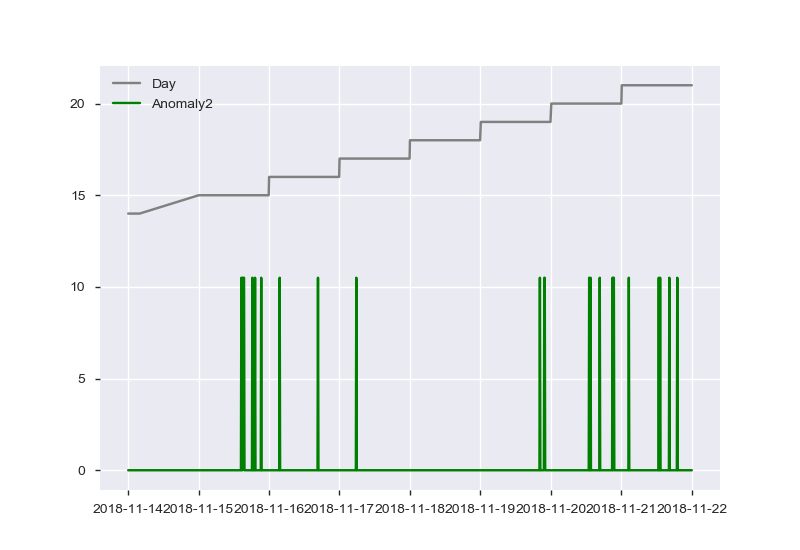

<IPython.core.display.Javascript object>


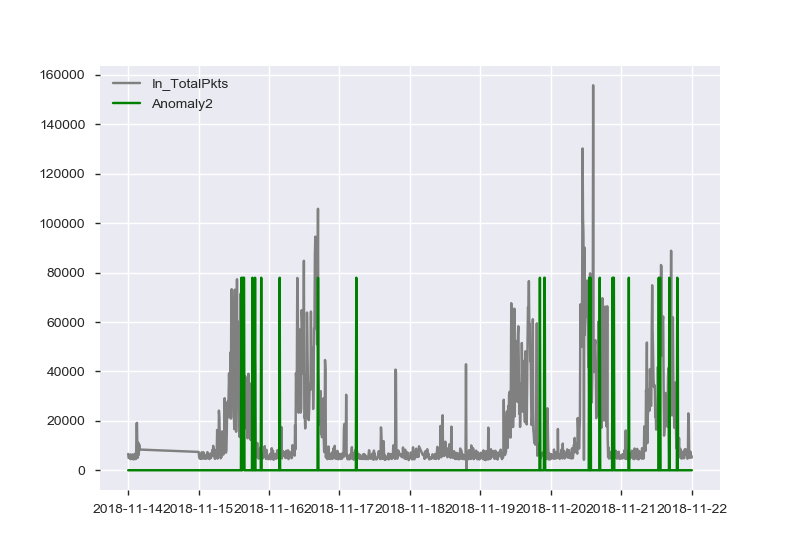

<IPython.core.display.Javascript object>


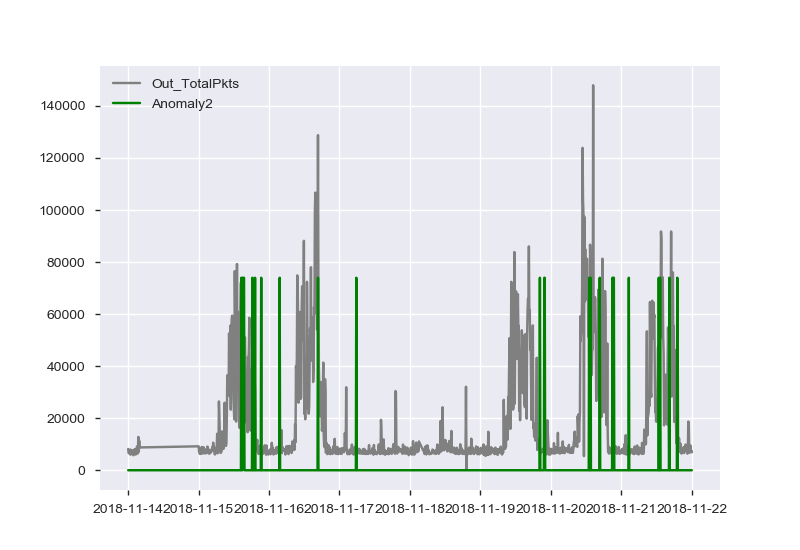

<IPython.core.display.Javascript object>


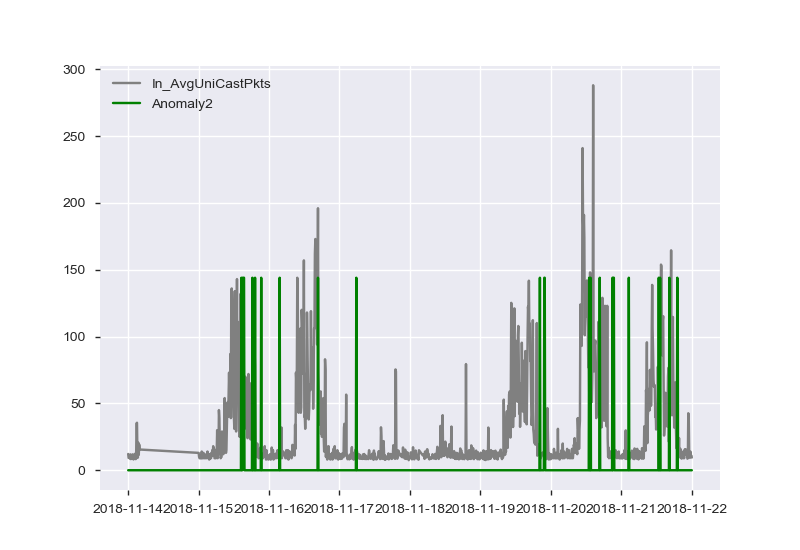

<IPython.core.display.Javascript object>


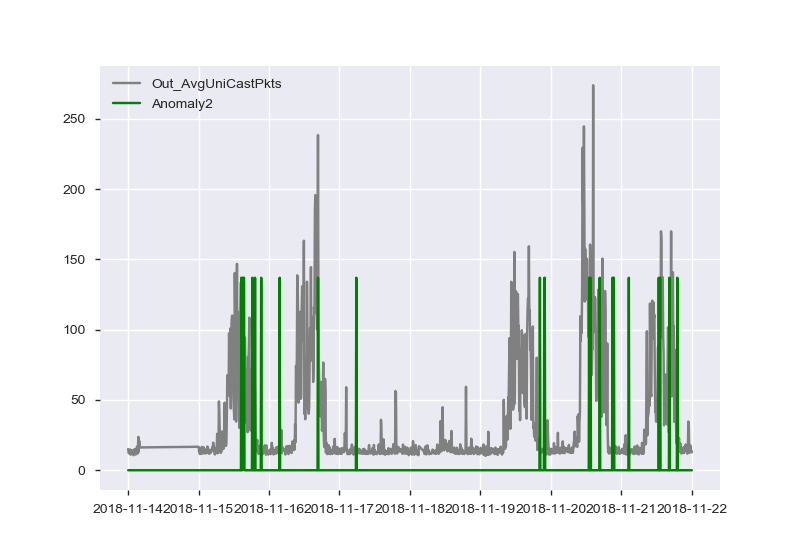

<IPython.core.display.Javascript object>


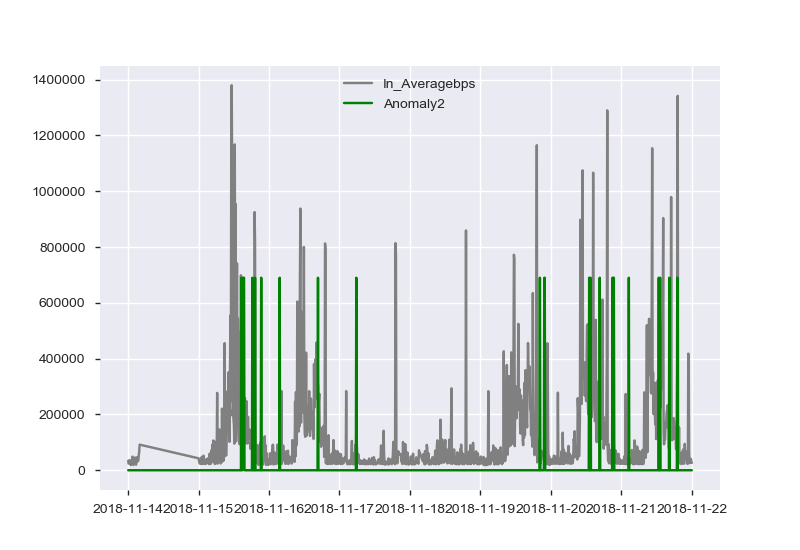

In [19]:
x = df4model['DateTime']

for column in columns[1:8]:
    fig, ax = plt.subplots()
    y1 = df4model[column]
    y4 = df4model['Anomaly2']*df4model[column].max() *0.5
    ax.plot(x, y1,  color='grey')
    ax.plot(x, y4,  color='g')
    plt.legend()
    plt.show()

# Future Steps

(This notebook is only for demo purposes)

    - More Data its needed to get adequate results
    - Set up two flows (supervised and unsupervised) to create more models
    - Check data to create more features and find patterns
